## Re-compute regression slopes from scratch. 
Maybe there's a bug in my other code? It's weird that (a) daily correlations aren't showing more agreement than monthly for sfc fluxes and mean wind speed, and (b) that monthly wind variances are more correlated with those sfc fluxes than mean winds are. <br>
SO - let's start from scratch, and try to be very purposeful in the implementation. Check that each thing makes sense. <br><br>
<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 4 Nov 2020 (what a day...) <br>

In [27]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib.animation as animation
import matplotlib as matplotlib
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
#import regionmask
import pickle
import scipy.stats as stats
import glob


## 1. Start with the monthly stuff. Is variance really more strongly correlated with sfc fluxes than mean winds? 

### 1.1 Read in data

In [2]:
# Set up directories 
dataDir    = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/'
nameStart  = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.'
nameEnd    = '_CLUBBwinds.nc'
nameEnd_UV = '_UV.nc'
nameEnd_FLX  = '_sfcFluxes.nc'

# Using fewer years here for comparison 
decadeList = ['1970-79','1980-89','1990-99']

In [3]:
# Read in single history file to get lat/lon and masks 
testName = dataDir+'f.e20.FHIST.f09_f09.cesm2_1.001.clm2.h0.1989-12.nc'
testDF   = xr.open_dataset(testName)

# Set lat, lon 
lat = testDF.lat
lon = testDF.lon

# Make land mask
landMask              = testDF.landmask.values
landMask[landMask==0] = np.nan

# Ideally, want to mask out Greenland/Antarctica too (ice sheets)
iceContent = testDF.ICE_CONTENT1.values[0,:,:]  # "Initial gridcell total ice content"
iceMask    = np.full([len(lat),len(lon)], np.nan)
iceMask[iceContent<10000] = 1

<ipython-input-3-34d10c66cbdc>:16: RuntimeWarning: invalid value encountered in less
  iceMask[iceContent<10000] = 1


In [4]:
# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 
    fileName       = dataDir+nameStart+decadeList[iDec]+nameEnd
    dataDF         = xr.open_dataset(fileName, decode_times=True)
    dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    UVfile         = dataDir+nameStart+decadeList[iDec]+nameEnd_UV 
    windDF         = xr.open_dataset(UVfile, decode_times=True)
    windDF['time'] = windDF.indexes['time'].to_datetimeindex()
    
    
    FLXfile       = dataDir+nameStart+decadeList[iDec]+nameEnd_FLX
    flxDF         = xr.open_dataset(FLXfile, decode_times=True)
    flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()

    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
        fullDF   = dataDF
        fullUV   = windDF
        fullFLX  = flxDF
    else:
        fullDF   = xr.concat([fullDF, dataDF], dim="time")
        fullUV   = xr.concat([fullUV, windDF], dim="time")
        fullFLX  = xr.concat([fullFLX, flxDF], dim="time")
        
    print('Done with decade ', decadeList[iDec], ' ... ')
    print('    Number of times saved: ', len(fullDF['time']))
    

<ipython-input-4-6975efa4b9e5>:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime
<ipython-input-4-6975efa4b9e5>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  windDF['time'] = windDF.indexes['time'].to_datetimeindex()
<ipython-input-4-6975efa4b9e5>:16: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors i

Done with decade  1970-79  ... 
    Number of times saved:  120
Done with decade  1980-89  ... 
    Number of times saved:  240
Done with decade  1990-99  ... 
    Number of times saved:  360


In [5]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(fullDF['time'].values) 

# Let's set the monthly averages to be roughly mid-month
#   This way, the average for January has a month of 1 instead of being the first day of February 
midTime = dates - timedelta(days=15)       


### 1.2 Isolate variables and get mean *surface* wind and variance

In [6]:
# Read into individual arrays for easy access

UP2   = fullDF.UP2_CLUBB.values      # Zonal velocity variance (m2/s2)
VP2   = fullDF.VP2_CLUBB.values      # Meridional velocity variance (m2/s2)
SHFLX = fullFLX.SHFLX.values
LHFLX = fullFLX.LHFLX.values
U     = fullUV.U.values              # Zonal wind (m/s)
V     = fullUV.V.values              # Meridional wind (m/s)


In [7]:
# Flip along vertical (level) axis, so that index 0 is surface 

UP2 = np.flip(UP2, axis=1)
VP2 = np.flip(VP2, axis=1)
U   = np.flip(U,   axis=1)
V   = np.flip(V,   axis=1)

# Save levels themselves to arrays and flip them too (avoids confusion later, hopefully)
lev_interface = np.flip(fullDF.ilev.values)
lev_middle    = np.flip(fullUV.lev.values)


In [8]:
print('First 5 middle levels: ')
print('      ', lev_middle[0:5])
print()
print('First 5 interface levels:')
print('      ', lev_interface[0:5])


First 5 middle levels: 
       [992.55609512 976.32540739 957.48547954 936.19839847 912.64454694]

First 5 interface levels:
       [1000.          985.11219025  967.53862454  947.43233453  924.96446241]


In [9]:
# Now get surface wind magnitude and combine variances 
windSpd = np.sqrt(U**2 + V**2)
windVar = UP2 + VP2 


In [10]:
# print('Temporal/Global mean windSpd at each level: ')
# print( np.nanmean((np.nanmean(np.nanmean(windSpd,axis=3),axis=2)),axis=0) )
# print()
# print('Temporal/Global mean windVar at each level: ')
# print( np.nanmean((np.nanmean(np.nanmean(windVar,axis=3),axis=2)),axis=0) )
# print()

Temporal/Global mean windSpd at each level: 
[ 5.0252705  6.2128854  6.276378   6.3118963  6.3009276  6.25549
  6.208403   6.2227073  6.4324102  6.96679    7.8094273  8.9509325
 10.342524  11.904425  13.561715  15.139706  16.367298  16.99747
 16.976198  16.415545  15.381046  14.037176  12.935652  12.284852
 12.068645  12.241459  12.753685  13.7663355 15.869195  19.525778
 25.25781   32.59112  ]

Temporal/Global mean windVar at each level: 
[0.72891957 0.31096578 0.21774136 0.168348   0.13345078 0.10786533
 0.08722195 0.06768778 0.03951283 0.01842509 0.00950971 0.00682905
 0.00698649 0.007167   0.00731742 0.00803744 0.00917466 0.00946472
 0.00813144 0.00543063 0.00276251 0.00135597 0.00090185 0.00081041
 0.00080262 0.00080188 0.00080155 0.00080137 0.00080142 0.00080184
 0.00080079 0.00080008 0.0008    ]



In [10]:
# Get seasonal indices 
iDJF = np.where((midTime.month==12) | (midTime.month<=2))[0]
iMAM = np.where((midTime.month>=3)  & (midTime.month<=5))[0]
iJJA = np.where((midTime.month>=6)  & (midTime.month<=8))[0]
iSON = np.where((midTime.month>=9)  & (midTime.month<=11))[0]

# Select near surface speed and variance 
sfcWindSpd = windSpd[:,0,:,:]
sfcWindVar = windVar[:,1,:,:]

### 1.3 Use only land points, and pick out JJA first

In [11]:
# Use only land points... (and exclude ice sheets)
sfcWindSpd_land = sfcWindSpd*landMask*iceMask
sfcWindVar_land = sfcWindVar*landMask*iceMask
SHFLX_land      = SHFLX*landMask*iceMask
LHFLX_land      = LHFLX*landMask*iceMask

# Also consider using the bowen ratio or EF rather than fluxes individually (more holistic energy concept)
EF_land         = LHFLX_land / (LHFLX_land + SHFLX_land)
bowen_land      = SHFLX_land / LHFLX_land
totalFlx_land   = SHFLX_land+LHFLX_land


In [12]:
# Now pick out JJA values: 
sfcWindSpd_JJA = sfcWindSpd_land[iJJA,:,:]
sfcWindVar_JJA = sfcWindVar_land[iJJA,:,:]
SHFLX_JJA      = SHFLX_land[iJJA,:,:]
LHFLX_JJA      = LHFLX_land[iJJA,:,:]
EF_JJA         = EF_land[iJJA,:,:]
bowen_JJA      = bowen_land[iJJA,:,:]
totalFlx_JJA   = totalFlx_land[iJJA,:,:]


### 1.4 Test out regression methods

I've been using scipy.stats.linregress, for reference 

#### 1.4.1 Check out two points (Amazon and SGP) and compute the correlation coefficient two ways

In [15]:
# Amazon point
ilat = 92
ilon = 244

slope, intercept, r_value, p_value, std_err = stats.linregress(sfcWindSpd_JJA[:,ilat,ilon], 
                                                               SHFLX_JJA[:,ilat,ilon])
print('Spd_v_SHFLX r_value: ', r_value)

slope, intercept, r_value, p_value, std_err = stats.linregress(sfcWindVar_JJA[:,ilat,ilon], 
                                                               SHFLX_JJA[:,ilat,ilon])
print('Var_v_SHFLX r_value: ', r_value)

Spd_v_SHFLX r_value:  0.7568654138847057
Var_v_SHFLX r_value:  0.9071803767302927


In [16]:
print('Using np.corrcoef instead of scipy.stats.linregress...')
print('Spd_v_SHFLX corrCoef: ', np.corrcoef(sfcWindSpd_JJA[:,ilat,ilon], SHFLX_JJA[:,ilat,ilon])[0,1])
print('Var_v_SHFLX corrCoef: ', np.corrcoef(sfcWindVar_JJA[:,ilat,ilon], SHFLX_JJA[:,ilat,ilon])[0,1])

Using np.corrcoef instead of scipy.stats.linregress...
Spd_v_SHFLX corrCoef:  0.7568654138847057
Var_v_SHFLX corrCoef:  0.9071803767302925


Text(0.23, 52, 'CorrCoef: 0.91')

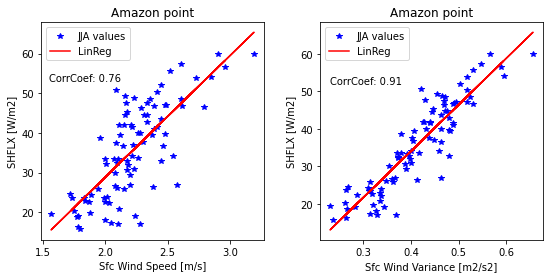

In [50]:
fig, axs = plt.subplots(1,2, figsize=(9, 4))
#Put axs handles in array, axs 
axs = axs.ravel()
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.25)

# ---- Plot wind speed vs. SHFLX
slope, intercept, r_value, p_value, std_err = stats.linregress(sfcWindSpd_JJA[:,ilat,ilon], 
                                                               SHFLX_JJA[:,ilat,ilon])

axs[0].plot(sfcWindSpd_JJA[:,ilat,ilon], SHFLX_JJA[:,ilat,ilon], 'b*')
axs[0].plot(sfcWindSpd_JJA[:,ilat,ilon], intercept + slope*sfcWindSpd_JJA[:,ilat,ilon], 'r-')
axs[0].set_title('Amazon point')
axs[0].set_xlabel('Sfc Wind Speed [m/s]')
axs[0].set_ylabel('SHFLX [W/m2]')
axs[0].legend(['JJA values','LinReg'])
axs[0].text(1.55,53,'CorrCoef: %.2f' % r_value)

# ---- Plot wind variance vs. SHFLX
slope, intercept, r_value, p_value, std_err = stats.linregress(sfcWindVar_JJA[:,ilat,ilon], 
                                                               SHFLX_JJA[:,ilat,ilon])

axs[1].plot(sfcWindVar_JJA[:,ilat,ilon], SHFLX_JJA[:,ilat,ilon], 'b*')
axs[1].plot(sfcWindVar_JJA[:,ilat,ilon], intercept + slope*sfcWindVar_JJA[:,ilat,ilon], 'r-')
axs[1].set_title('Amazon point')
axs[1].set_xlabel('Sfc Wind Variance [m2/s2]')
axs[1].set_ylabel('SHFLX [W/m2]')
axs[1].legend(['JJA values','LinReg'])
axs[1].text(0.23,52,'CorrCoef: %.2f' % r_value)


How about checking a point a bit easier to understand (hopefully) than a point in the Amazon. Let's check the SGP point I've been using. 

In [17]:
# SGP site
ilat = np.where( (lat>=35.5) & (lat<=36.5))[0][0]
ilon = np.where( (lon>=261.5) & (lon<=262.5) )[0][0]

slope, intercept, r_value, p_value, std_err = stats.linregress(sfcWindSpd_JJA[:,ilat,ilon], 
                                                               SHFLX_JJA[:,ilat,ilon])
print('Spd_v_SHFLX r_value: ', r_value)

slope, intercept, r_value, p_value, std_err = stats.linregress(sfcWindVar_JJA[:,ilat,ilon], 
                                                               SHFLX_JJA[:,ilat,ilon])
print('Var_v_SHFLX r_value: ', r_value)


Spd_v_SHFLX r_value:  0.31662496738809753
Var_v_SHFLX r_value:  0.6133927746198902


In [18]:
print('Using np.corrcoef instead of scipy.stats.linregress...')
print('Spd_v_SHFLX corrCoef: ', np.corrcoef(sfcWindSpd_JJA[:,ilat,ilon], SHFLX_JJA[:,ilat,ilon])[0,1])
print('Var_v_SHFLX corrCoef: ', np.corrcoef(sfcWindVar_JJA[:,ilat,ilon], SHFLX_JJA[:,ilat,ilon])[0,1])

Using np.corrcoef instead of scipy.stats.linregress...
Spd_v_SHFLX corrCoef:  0.3166249673880975
Var_v_SHFLX corrCoef:  0.6133927746198902


Text(0.42, 98, 'CorrCoef: 0.61')

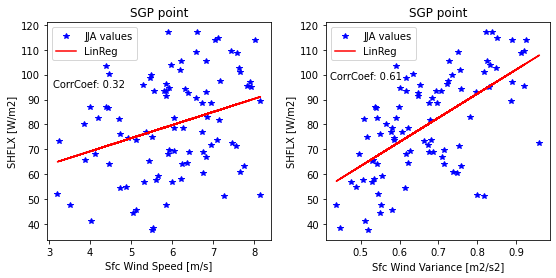

In [61]:
fig, axs = plt.subplots(1,2, figsize=(9, 4))
#Put axs handles in array, axs 
axs = axs.ravel()
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.25)

# ---- Plot wind speed vs. SHFLX
slope, intercept, r_value, p_value, std_err = stats.linregress(sfcWindSpd_JJA[:,ilat,ilon], 
                                                               SHFLX_JJA[:,ilat,ilon])

axs[0].plot(sfcWindSpd_JJA[:,ilat,ilon], SHFLX_JJA[:,ilat,ilon], 'b*')
axs[0].plot(sfcWindSpd_JJA[:,ilat,ilon], intercept + slope*sfcWindSpd_JJA[:,ilat,ilon], 'r-')
axs[0].set_title('SGP point')
axs[0].set_xlabel('Sfc Wind Speed [m/s]')
axs[0].set_ylabel('SHFLX [W/m2]')
axs[0].legend(['JJA values','LinReg'])
axs[0].text(3.1,95,'CorrCoef: %.2f' % r_value)

# ---- Plot wind variance vs. SHFLX
slope, intercept, r_value, p_value, std_err = stats.linregress(sfcWindVar_JJA[:,ilat,ilon], 
                                                               SHFLX_JJA[:,ilat,ilon])

axs[1].plot(sfcWindVar_JJA[:,ilat,ilon], SHFLX_JJA[:,ilat,ilon], 'b*')
axs[1].plot(sfcWindVar_JJA[:,ilat,ilon], intercept + slope*sfcWindVar_JJA[:,ilat,ilon], 'r-')
axs[1].set_title('SGP point')
axs[1].set_xlabel('Sfc Wind Variance [m2/s2]')
axs[1].set_ylabel('SHFLX [W/m2]')
axs[1].legend(['JJA values','LinReg'])
axs[1].text(0.42,98,'CorrCoef: %.2f' % r_value)



#### 1.4.2 That all seems to be correct then... Try globally? 

In [19]:
def linRegress3D(xVar, yVar):
    
    # Get length of lat/lon dimensions 
    shapeDat = np.shape(xVar)
    nlat     = shapeDat[1]
    nlon     = shapeDat[2]
    
    # Define empty arrays to return 
    slope     = np.full([nlat, nlon], np.nan)
    intercept = np.full([nlat, nlon], np.nan)
    rValue    = np.full([nlat, nlon], np.nan)
    pValue    = np.full([nlat, nlon], np.nan)
    
    for ilat in range(nlat):
        for ilon in range(nlon): 
            x = xVar[:,ilat,ilon]
            y = yVar[:,ilat,ilon]

            # Perform linear regression
            slope[ilat,ilon], intercept[ilat,ilon], rValue[ilat,ilon], pValue[ilat,ilon], std_err = stats.linregress(x, y)

    return(slope,intercept,rValue,pValue)



Try without function first?

In [13]:
# Regression between wind SPEED and SHFLX 
#   Using abs(SHFLX)

# Define empty arrays...
slope_spdSH  = np.full([len(lat), len(lon)], np.nan)
rValue_spdSH = np.full([len(lat), len(lon)], np.nan)
slope_spdLH  = np.full([len(lat), len(lon)], np.nan)
rValue_spdLH = np.full([len(lat), len(lon)], np.nan)
slope_spdTotal = np.full([len(lat), len(lon)], np.nan)
rValue_spdTotal = np.full([len(lat), len(lon)], np.nan)
slope_spdBowen = np.full([len(lat), len(lon)], np.nan)
rValue_spdBowen = np.full([len(lat), len(lon)], np.nan)

for ilat in range(len(lat)):
    for ilon in range(len(lon)):
        
        # Perform linear regression
        slope_spdSH[ilat,ilon], intrcpt, rValue_spdSH[ilat,ilon], pVal, std_err = stats.linregress(sfcWindSpd_JJA[:,ilat,ilon],
                                                                                                   np.abs(SHFLX_JJA[:,ilat,ilon]))

        slope_spdLH[ilat,ilon], intrcpt, rValue_spdLH[ilat,ilon], pVal, std_err = stats.linregress(sfcWindSpd_JJA[:,ilat,ilon],
                                                                                                   np.abs(LHFLX_JJA[:,ilat,ilon]))

        slope_spdTotal[ilat,ilon], intrcpt, rValue_spdTotal[ilat,ilon], pVal, std_err = stats.linregress(sfcWindSpd_JJA[:,ilat,ilon],
                                                                                                   totalFlx_JJA[:,ilat,ilon])

        slope_spdBowen[ilat,ilon], intrcpt, rValue_spdBowen[ilat,ilon], pVal, std_err = stats.linregress(sfcWindSpd_JJA[:,ilat,ilon],
                                                                                                   bowen_JJA[:,ilat,ilon])




In [14]:
# Regression between wind VARIANCE and SHFLX
#  Using abs(SHFLX)

# Define empty arrays...
slope_varSH  = np.full([len(lat), len(lon)], np.nan)
rValue_varSH = np.full([len(lat), len(lon)], np.nan)
slope_varLH  = np.full([len(lat), len(lon)], np.nan)
rValue_varLH = np.full([len(lat), len(lon)], np.nan)
slope_varTotal  = np.full([len(lat), len(lon)], np.nan)
rValue_varTotal = np.full([len(lat), len(lon)], np.nan)
slope_varBowen  = np.full([len(lat), len(lon)], np.nan)
rValue_varBowen = np.full([len(lat), len(lon)], np.nan)

for ilat in range(len(lat)):
    for ilon in range(len(lon)):
        
        # Perform linear regression
        slope_varSH[ilat,ilon], intrcpt, rValue_varSH[ilat,ilon], pVal, std_err = stats.linregress(sfcWindVar_JJA[:,ilat,ilon],
                                                                                                   np.abs(SHFLX_JJA[:,ilat,ilon]))

        slope_varLH[ilat,ilon], intrcpt, rValue_varLH[ilat,ilon], pVal, std_err = stats.linregress(sfcWindVar_JJA[:,ilat,ilon],
                                                                                                   np.abs(LHFLX_JJA[:,ilat,ilon]))


        slope_varTotal[ilat,ilon], intrcpt, rValue_varTotal[ilat,ilon], pVal, std_err = stats.linregress(sfcWindVar_JJA[:,ilat,ilon],
                                                                                                   totalFlx_JJA[:,ilat,ilon])
        
        slope_varBowen[ilat,ilon], intrcpt, rValue_varBowen[ilat,ilon], pVal, std_err = stats.linregress(sfcWindVar_JJA[:,ilat,ilon],
                                                                                                   bowen_JJA[:,ilat,ilon])


**Make some plots describing above data**

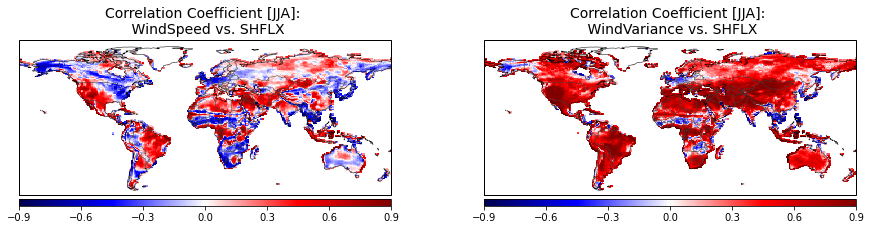

In [126]:
# ---- Maps of correlation coefficients ---- # 

# Make corrcoef cyclic for plotting
rValue_spdSH_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(rValue_spdSH, lon)
rValue_varSH_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(rValue_varSH, lon)

# Set up figure
fig, axs = plt.subplots(1,2, figsize=(15, 5),subplot_kw={'projection':ccrs.PlateCarree()})
#Put axs handles in array, axs 
axs = axs.ravel()
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.25)
# Set limits of plot
axs[0].set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
axs[1].set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
# Add coastlines 
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# Plot spd vs. SH 
contour_plot = axs[0].pcolormesh(lon_cyclic,lat, rValue_spdSH_cyclic,
                                 vmax = 0.9, vmin = -0.9, cmap = 'seismic')
axs[0].set_title('Correlation Coefficient [JJA]: \n WindSpeed vs. SHFLX', fontsize=14)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

# Plot var vs. SH
contour_plot = axs[1].pcolormesh(lon_cyclic,lat, rValue_varSH_cyclic,
                                 vmax = 0.9, vmin = -0.9, cmap = 'seismic')
axs[1].set_title('Correlation Coefficient [JJA]: \n WindVariance vs. SHFLX', fontsize=14)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()


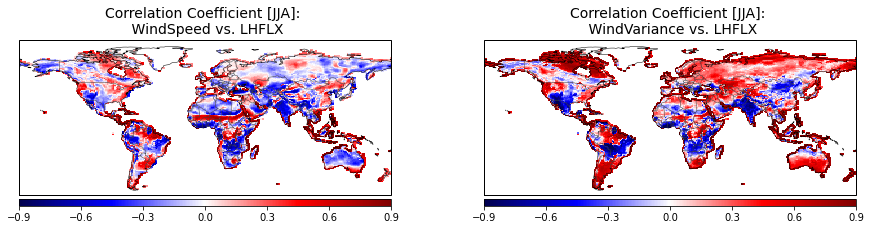

In [62]:
# ---- Maps of correlation coefficients ---- # 

# Make corrcoef cyclic for plotting
rValue_spdLH_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(rValue_spdLH, lon)
rValue_varLH_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(rValue_varLH, lon)

# Set up figure
fig, axs = plt.subplots(1,2, figsize=(15, 5),subplot_kw={'projection':ccrs.PlateCarree()})
#Put axs handles in array, axs 
axs = axs.ravel()
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.25)
# Set limits of plot
axs[0].set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
axs[1].set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
# Add coastlines 
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# Plot spd vs. LH 
contour_plot = axs[0].pcolormesh(lon_cyclic,lat, rValue_spdLH_cyclic,
                                 vmax = 0.9, vmin = -0.9, cmap = 'seismic')
axs[0].set_title('Correlation Coefficient [JJA]: \n WindSpeed vs. LHFLX', fontsize=14)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

# Plot var vs. LH
contour_plot = axs[1].pcolormesh(lon_cyclic,lat, rValue_varLH_cyclic,
                                 vmax = 0.9, vmin = -0.9, cmap = 'seismic')
axs[1].set_title('Correlation Coefficient [JJA]: \n WindVariance vs. LHFLX', fontsize=14)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()



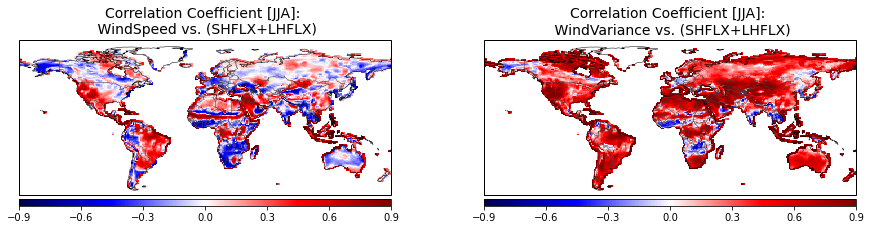

In [63]:
# ---- Maps of correlation coefficients ---- # 

# Make corrcoef cyclic for plotting
rValue_spdTotal_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(rValue_spdTotal, lon)
rValue_varTotal_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(rValue_varTotal, lon)

# Set up figure
fig, axs = plt.subplots(1,2, figsize=(15, 5),subplot_kw={'projection':ccrs.PlateCarree()})
#Put axs handles in array, axs 
axs = axs.ravel()
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.25)
# Set limits of plot
axs[0].set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
axs[1].set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
# Add coastlines 
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# Plot spd vs. total sfc fluxes 
contour_plot = axs[0].pcolormesh(lon_cyclic,lat, rValue_spdTotal_cyclic,
                                 vmax = 0.9, vmin = -0.9, cmap = 'seismic')
axs[0].set_title('Correlation Coefficient [JJA]: \n WindSpeed vs. (SHFLX+LHFLX)', fontsize=14)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

# Plot var vs. total sfc fluxes
contour_plot = axs[1].pcolormesh(lon_cyclic,lat, rValue_varTotal_cyclic,
                                 vmax = 0.9, vmin = -0.9, cmap = 'seismic')
axs[1].set_title('Correlation Coefficient [JJA]: \n WindVariance vs. (SHFLX+LHFLX)', fontsize=14)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()




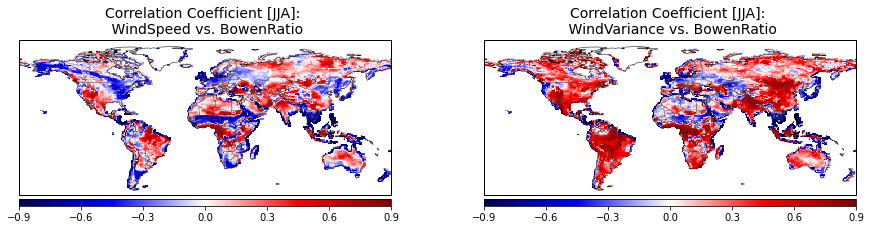

In [66]:
# ---- Maps of correlation coefficients ---- # 

# Make corrcoef cyclic for plotting
rValue_spdBowen_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(rValue_spdBowen, lon)
rValue_varBowen_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(rValue_varBowen, lon)

# Set up figure
fig, axs = plt.subplots(1,2, figsize=(15, 5),subplot_kw={'projection':ccrs.PlateCarree()})
#Put axs handles in array, axs 
axs = axs.ravel()
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.25)
# Set limits of plot
axs[0].set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
axs[1].set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
# Add coastlines 
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# Plot spd vs. bowen ratio
contour_plot = axs[0].pcolormesh(lon_cyclic,lat, rValue_spdBowen_cyclic,
                                 vmax = 0.9, vmin = -0.9, cmap = 'seismic')
axs[0].set_title('Correlation Coefficient [JJA]: \n WindSpeed vs. BowenRatio', fontsize=14)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

# Plot var vs. bowen ratio
contour_plot = axs[1].pcolormesh(lon_cyclic,lat, rValue_varBowen_cyclic,
                                 vmax = 0.9, vmin = -0.9, cmap = 'seismic')
axs[1].set_title('Correlation Coefficient [JJA]: \n WindVariance vs. BowenRatio', fontsize=14)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()


**Trying to figure out the negative correlations in the monthly data...**

/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


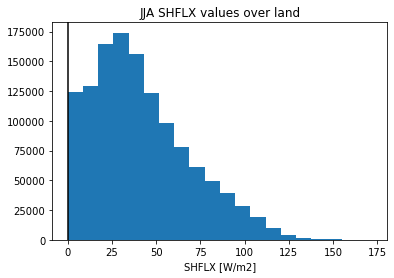

Fraction of land grid cells with SH<0: 0.02787


<ipython-input-127-dba3ef770220>:7: RuntimeWarning: invalid value encountered in less
  fracNegSH = len(np.where(SHFLX_JJA<0)[0]) / len(np.where(np.isfinite(SHFLX_JJA)==True)[0])


In [127]:
plt.hist(np.abs(SHFLX_JJA).reshape(len(lat)*len(lon)*np.shape(SHFLX_JJA)[0]),bins=20)
plt.axvline(0,color='k')
plt.title('JJA SHFLX values over land')
plt.xlabel('SHFLX [W/m2]')
plt.show()

fracNegSH = len(np.where(SHFLX_JJA<0)[0]) / len(np.where(np.isfinite(SHFLX_JJA)==True)[0])
print('Fraction of land grid cells with SH<0: %.5f' % fracNegSH)


<ipython-input-53-52b5fce46e65>:2: RuntimeWarning: invalid value encountered in less
  iNeg_rows, iNeg_cols = np.where(rValue_spdSH<0)


Text(0, 0.5, 'LHFLX+SHFLX')

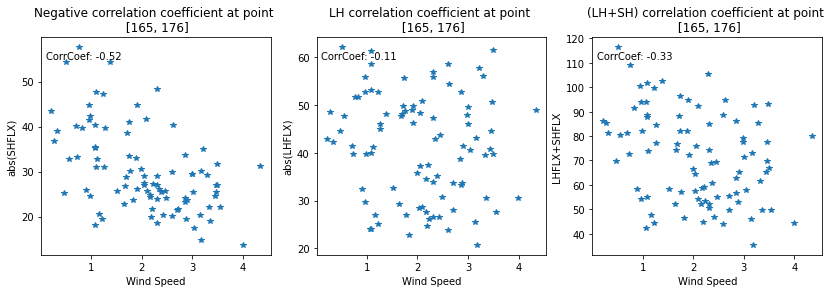

In [53]:
# Find where slope between wind speed and SHFLX is negative...
iNeg_rows, iNeg_cols = np.where(rValue_spdSH<0)

SH_neg    = np.abs(SHFLX_JJA[:,iNeg_rows, iNeg_cols])
spd_neg   = sfcWindSpd_JJA[:, iNeg_rows, iNeg_cols]
rVal_neg  = rValue_spdSH[iNeg_rows, iNeg_cols]

iPoint    = 5581

SH_point    = np.abs(SHFLX_JJA[:,iNeg_rows[iPoint], iNeg_cols[iPoint]])
spd_point   = sfcWindSpd_JJA[:, iNeg_rows[iPoint], iNeg_cols[iPoint]]
LH_point    = np.abs(LHFLX_JJA[:,iNeg_rows[iPoint], iNeg_cols[iPoint]])
total_point = totalFlx_JJA[:,iNeg_rows[iPoint], iNeg_cols[iPoint]]

rStr      = rValue_spdSH[iNeg_rows[iPoint],iNeg_cols[iPoint]]
rStr_LH   = rValue_spdLH[iNeg_rows[iPoint],iNeg_cols[iPoint]]
rStr_total = rValue_spdTotal[iNeg_rows[iPoint],iNeg_cols[iPoint]]

# Scatter plot
fig, axs  = plt.subplots(1,3, figsize=(14, 4))
axs       = axs.ravel()

axs[0].plot(spd_point,SH_point,'*')
axs[0].text(0.02,0.9,'CorrCoef: %.2f' % rStr,transform=axs[0].transAxes)
axs[0].set_title('Negative correlation coefficient at point \n [%i, %i]' % (iNeg_rows[iPoint], iNeg_cols[iPoint]))
axs[0].set_xlabel('Wind Speed')
axs[0].set_ylabel('abs(SHFLX)')

axs[1].plot(spd_point,LH_point,'*')
axs[1].text(0.02,0.9,'CorrCoef: %.2f' % rStr_LH, transform=axs[1].transAxes)
axs[1].set_title('LH correlation coefficient at point \n [%i, %i]' % (iNeg_rows[iPoint], iNeg_cols[iPoint]))
axs[1].set_xlabel('Wind Speed')
axs[1].set_ylabel('abs(LHFLX)')

axs[2].plot(spd_point,total_point,'*')
axs[2].text(0.02,0.9,'CorrCoef: %.2f' % rStr_total, transform=axs[2].transAxes)
axs[2].set_title('(LH+SH) correlation coefficient at point \n [%i, %i]' % (iNeg_rows[iPoint], iNeg_cols[iPoint]))
axs[2].set_xlabel('Wind Speed')
axs[2].set_ylabel('LHFLX+SHFLX')


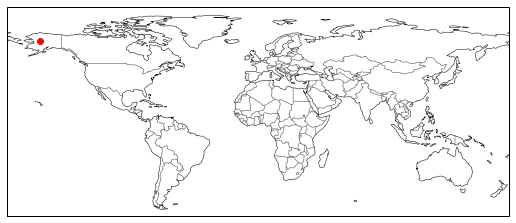

In [38]:
# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(9, 5),subplot_kw={'projection':ccrs.PlateCarree()})
# Set limits of plot
ax1.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax1.plot(lon[163],lat[165],'r.',markersize=12,transform=ccrs.PlateCarree())



In [134]:
np.where(rVal_neg<-0.5)

(array([  52,   57,   59,   66,   68,   69,   77,  129,  130,  145,  154,
         174,  180,  181,  182,  183,  184,  185,  203,  204,  205,  206,
         207,  208,  209,  210,  235,  236,  237,  238,  239,  240,  241,
         245,  277,  279,  281,  282,  283,  284,  285,  287,  289,  318,
         321,  322,  324,  325,  326,  327,  363,  368,  369,  370,  371,
         372,  373,  406,  409,  414,  415,  416,  417,  452,  453,  454,
         455,  456,  486,  491,  492,  493,  494,  521,  522,  524,  550,
         553,  554,  584,  588,  620,  623,  624,  644,  658,  661,  662,
         679,  697,  711,  712,  713,  714,  747,  748,  749,  804,  810,
         833,  845,  850,  888,  895,  912,  913,  945,  948,  970,  978,
         979, 1006, 1012, 1034, 1044, 1045, 1048, 1051, 1065, 1073, 1074,
        1095, 1104, 1113, 1134, 1157, 1163, 1207, 1208, 1210, 1212, 1218,
        1220, 1237, 1238, 1243, 1244, 1276, 1290, 1297, 1316, 1318, 1332,
        1342, 1351, 1428, 1429, 1448, 

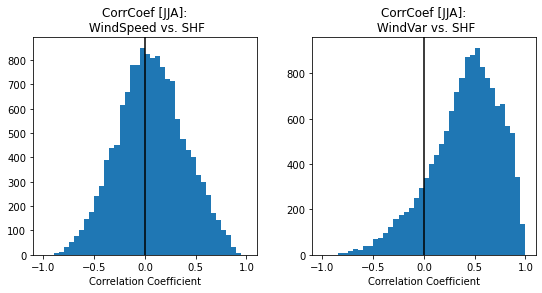

In [39]:
# ---- Histograms of correlation coefficients ---- # 
fig, axs = plt.subplots(1,2, figsize=(9, 4))
#Put axs handles in array, axs 
axs = axs.ravel()
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.25)

binEdges = np.arange(-1,1.05,0.05)

# --- Plot histogram for corrCoef of spd vs. SH 
axs[0].hist(rValue_spdSH.reshape(len(lat)*len(lon)),bins=binEdges)
axs[0].set_title('CorrCoef [JJA]:\n WindSpeed vs. SHF')
axs[0].set_xlabel('Correlation Coefficient')
axs[0].axvline(0,color='k')

# --- Plot histogram for corrCoef of var vs. SH 
axs[1].hist(rValue_varSH.reshape(len(lat)*len(lon)),bins=binEdges)
axs[1].set_title('CorrCoef [JJA]:\n WindVar vs. SHF')
axs[1].set_xlabel('Correlation Coefficient')
axs[1].axvline(0,color='k')

plt.show()


## 2. Now move on to daily. Are correlations really worse than monthly for wind speed vs. SHF??
Do note though - reading in *daily* winds obviously takes a ton of memory. Either read in fewer years, or you will definitely need to refresh somewhere along the way and clear out memory from above part. 

### 2.1 Read in daily data

In [15]:
# Set up directories 
dataDir     = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/daily/'
nameStart   = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h1.'
nameEnd_UV  = '_sfcLevs-dailyUV.nc'
nameEnd_FLX = '_dailySfcFluxes.nc'

decadeList  = ['1970-79','1980-89','1990-99']


In [16]:
# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 
    UVfile         = dataDir+nameStart+decadeList[iDec]+nameEnd_UV 
    windDF         = xr.open_dataset(UVfile, decode_times=True)
    windDF['time'] = windDF.indexes['time'].to_datetimeindex()   
    
    FLXfile       = dataDir+nameStart+decadeList[iDec]+nameEnd_FLX
    flxDF         = xr.open_dataset(FLXfile, decode_times=True)
    flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
    
    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
        fullUV   = windDF
        fullFLX  = flxDF
    else:
        fullUV   = xr.concat([fullUV, windDF], dim="time")
        fullFLX  = xr.concat([fullFLX, flxDF], dim="time")
        
    # Close files 
    windDF.close() 
    flxDF.close()

    print('Done with decade ', decadeList[iDec], ' ... ')
    

<ipython-input-16-ea5f6278e3f1>:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  windDF['time'] = windDF.indexes['time'].to_datetimeindex()
<ipython-input-16-ea5f6278e3f1>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()


Done with decade  1970-79  ... 
Done with decade  1980-89  ... 
Done with decade  1990-99  ... 


In [17]:
# To be able to easily access years, months, days - use Pandas 
dates_daily = pd.DatetimeIndex(flxDF['time'].values) 

# Let's set the monthly averages to be roughly mid-month
#   This way, the average for January has a month of 1 instead of being the first day of February 
midTime_daily = dates_daily - timedelta(days=15) 

### 2.2 Flip levels and get total surface wind speed and variance 

In [18]:
# Read into individual arrays for easy access
SHFLX_daily = fullFLX.SHFLX.values
LHFLX_daily = fullFLX.LHFLX.values
U_daily     = fullUV.U.values              # Zonal wind (m/s)
V_daily     = fullUV.V.values              # Meridional wind (m/s)


In [19]:
# Flip along vertical (level) axis, so that index 0 is surface 
U_daily   = np.flip(U_daily,   axis=1)
V_daily   = np.flip(V_daily,   axis=1)

# Save levels themselves to arrays and flip them too (avoids confusion later, hopefully)
lev_middle    = np.flip(fullUV.lev.values)


In [20]:
# Now get surface wind magnitude and combine variances 
windSpd_daily = np.sqrt(U_daily**2 + V_daily**2)


In [21]:
# Get seasonal indices 
iDJF_daily = np.where((midTime_daily.month==12) | (midTime_daily.month<=2))[0]
iMAM_daily = np.where((midTime_daily.month>=3)  & (midTime_daily.month<=5))[0]
iJJA_daily = np.where((midTime_daily.month>=6)  & (midTime_daily.month<=8))[0]
iSON_daily = np.where((midTime_daily.month>=9)  & (midTime_daily.month<=11))[0]

# Select near surface speed and variance 
sfcWindSpd_daily = windSpd_daily[:,0,:,:]


In [22]:
# Use only land points... (and exclude ice sheets)
sfcWindSpd_land_daily = sfcWindSpd_daily*landMask*iceMask
SHFLX_land_daily      = SHFLX_daily*landMask*iceMask
LHFLX_land_daily      = LHFLX_daily*landMask*iceMask

# Also consider using the bowen ratio or EF rather than fluxes individually (more holistic energy concept)
EF_land_daily         = LHFLX_land_daily / (LHFLX_land_daily+ SHFLX_land_daily)
bowen_land_daily      = SHFLX_land_daily / LHFLX_land_daily
totalFlx_daily        = LHFLX_land_daily + SHFLX_land_daily


In [23]:
# Now pick out JJA values: 
sfcWindSpd_JJA_daily = sfcWindSpd_land_daily[iJJA_daily,:,:]
SHFLX_JJA_daily      = SHFLX_land_daily[iJJA_daily,:,:]
LHFLX_JJA_daily      = LHFLX_land_daily[iJJA_daily,:,:]
EF_JJA_daily         = EF_land_daily[iJJA_daily,:,:]
bowen_JJA_daily      = bowen_land_daily[iJJA_daily,:,:]
total_JJA_daily      = totalFlx_daily[iJJA_daily,:,:]


### 2.3 Test out regression methods again, just to be safe

In [183]:
# Amazon point
ilat = 92
ilon = 244

slope, intercept, r_value, p_value, std_err = stats.linregress(sfcWindSpd_JJA_daily[:,ilat,ilon], 
                                                               SHFLX_JJA_daily[:,ilat,ilon])
print('Spd_v_SHFLX r_value: ', r_value)

print('Using np.corrcoef instead of scipy.stats.linregress...')
print('Spd_v_SHFLX corrCoef: ', np.corrcoef(sfcWindSpd_JJA_daily[:,ilat,ilon], SHFLX_JJA_daily[:,ilat,ilon])[0,1])



Spd_v_SHFLX r_value:  0.4533933857485577
Using np.corrcoef instead of scipy.stats.linregress...
Spd_v_SHFLX corrCoef:  0.4533933857485576


Text(0.2, 62, 'CorrCoef: 0.45')

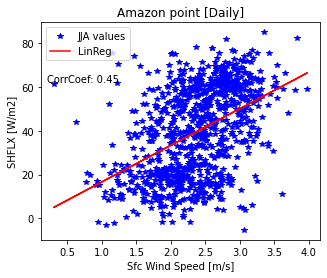

In [184]:
fig, ax1 = plt.subplots(1,1, figsize=(5, 4))

# ---- Plot wind speed vs. SHFLX
slope, intercept, r_value, p_value, std_err = stats.linregress(sfcWindSpd_JJA_daily[:,ilat,ilon], 
                                                               SHFLX_JJA_daily[:,ilat,ilon])

ax1.plot(sfcWindSpd_JJA_daily[:,ilat,ilon], SHFLX_JJA_daily[:,ilat,ilon], 'b*')
ax1.plot(sfcWindSpd_JJA_daily[:,ilat,ilon], intercept + slope*sfcWindSpd_JJA_daily[:,ilat,ilon], 'r-')
ax1.set_title('Amazon point [Daily]')
ax1.set_xlabel('Sfc Wind Speed [m/s]')
ax1.set_ylabel('SHFLX [W/m2]')
ax1.legend(['JJA values','LinReg'])
ax1.text(0.2,62,'CorrCoef: %.2f' % r_value)


In [185]:
# SGP site
ilat = np.where( (lat>=35.5) & (lat<=36.5))[0][0]
ilon = np.where( (lon>=261.5) & (lon<=262.5) )[0][0]

slope, intercept, r_value, p_value, std_err = stats.linregress(sfcWindSpd_JJA_daily[:,ilat,ilon], 
                                                               SHFLX_JJA_daily[:,ilat,ilon])
print('Spd_v_SHFLX r_value: ', r_value)

print('Using np.corrcoef instead of scipy.stats.linregress...')
print('Spd_v_SHFLX corrCoef: ', np.corrcoef(sfcWindSpd_JJA_daily[:,ilat,ilon], SHFLX_JJA_daily[:,ilat,ilon])[0,1])


Spd_v_SHFLX r_value:  0.38149899208541466
Using np.corrcoef instead of scipy.stats.linregress...
Spd_v_SHFLX corrCoef:  0.3814989920854146


Text(0.2, 141, 'CorrCoef: 0.38')

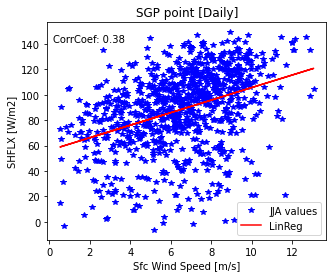

In [188]:
fig, ax1 = plt.subplots(1,1, figsize=(5, 4))

# ---- Plot wind speed vs. SHFLX
slope, intercept, r_value, p_value, std_err = stats.linregress(sfcWindSpd_JJA_daily[:,ilat,ilon], 
                                                               SHFLX_JJA_daily[:,ilat,ilon])

ax1.plot(sfcWindSpd_JJA_daily[:,ilat,ilon], SHFLX_JJA_daily[:,ilat,ilon], 'b*')
ax1.plot(sfcWindSpd_JJA_daily[:,ilat,ilon], intercept + slope*sfcWindSpd_JJA_daily[:,ilat,ilon], 'r-')
ax1.set_title('SGP point [Daily]')
ax1.set_xlabel('Sfc Wind Speed [m/s]')
ax1.set_ylabel('SHFLX [W/m2]')
ax1.legend(['JJA values','LinReg'])
ax1.text(0.2,141,'CorrCoef: %.2f' % r_value)



In [24]:
# Global regression between wind SPEED and abs(SHFLX) (daily means)

# Define empty arrays...
slope_spdSH_daily  = np.full([len(lat), len(lon)], np.nan)
rValue_spdSH_daily = np.full([len(lat), len(lon)], np.nan)
slope_spdLH_daily  = np.full([len(lat), len(lon)], np.nan)
rValue_spdLH_daily = np.full([len(lat), len(lon)], np.nan)
slope_spdTotal_daily  = np.full([len(lat), len(lon)], np.nan)
rValue_spdTotal_daily = np.full([len(lat), len(lon)], np.nan)

for ilat in range(len(lat)):
    for ilon in range(len(lon)):
        
        # Perform linear regression
        slope_spdSH_daily[ilat,ilon], intrcpt, rValue_spdSH_daily[ilat,ilon], pVal, std_err = stats.linregress(sfcWindSpd_JJA_daily[:,ilat,ilon],
                                                                                                   np.abs(SHFLX_JJA_daily[:,ilat,ilon]))

        slope_spdLH_daily[ilat,ilon], intrcpt, rValue_spdLH_daily[ilat,ilon], pVal, std_err = stats.linregress(sfcWindSpd_JJA_daily[:,ilat,ilon],
                                                                                                   np.abs(LHFLX_JJA_daily[:,ilat,ilon]))
        
        slope_spdTotal_daily[ilat,ilon], intrcpt, rValue_spdTotal_daily[ilat,ilon], pVal, std_err = stats.linregress(sfcWindSpd_JJA_daily[:,ilat,ilon],
                                                                                                   total_JJA_daily[:,ilat,ilon])
        

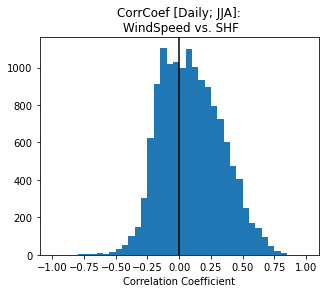

In [190]:
# ---- Histograms of correlation coefficients ---- # 
fig, ax1 = plt.subplots(1,1, figsize=(5, 4))
binEdges = np.arange(-1,1.05,0.05)

# --- Plot histogram for corrCoef of spd vs. SH 
ax1.hist(rValue_spdSH_daily.reshape(len(lat)*len(lon)),bins=binEdges)
ax1.set_title('CorrCoef [Daily; JJA]:\n WindSpeed vs. SHF')
ax1.set_xlabel('Correlation Coefficient')
ax1.axvline(0,color='k')

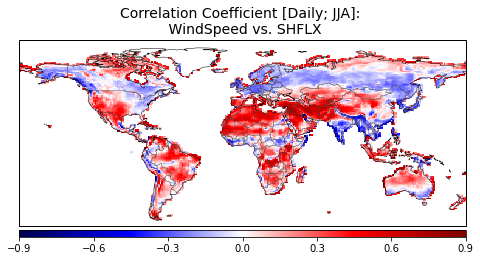

In [192]:
# ---- Maps of correlation coefficients ---- # 

# Make corrcoef cyclic for plotting
rValue_spdSH_daily_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(rValue_spdSH_daily, lon)

# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(8, 5),subplot_kw={'projection':ccrs.PlateCarree()})

# Set limits of plot
ax1.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# Plot spd vs. SH 
contour_plot = ax1.pcolormesh(lon_cyclic,lat, rValue_spdSH_daily_cyclic,
                                 vmax = 0.9, vmin = -0.9, cmap = 'seismic')
ax1.set_title('Correlation Coefficient [Daily; JJA]: \n WindSpeed vs. SHFLX', fontsize=14)
# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()



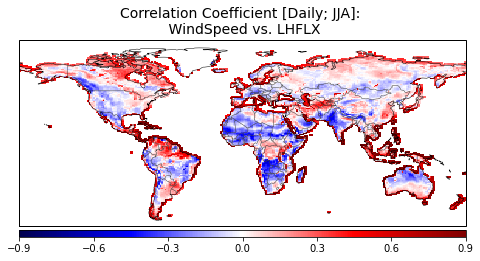

In [27]:
# ---- Maps of correlation coefficients ---- # 

# Make corrcoef cyclic for plotting
rValue_spdLH_daily_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(rValue_spdLH_daily, lon)

# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(8, 5),subplot_kw={'projection':ccrs.PlateCarree()})

# Set limits of plot
ax1.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# Plot spd vs. SH 
contour_plot = ax1.pcolormesh(lon_cyclic,lat, rValue_spdLH_daily_cyclic,
                                 vmax = 0.9, vmin = -0.9, cmap = 'seismic')
ax1.set_title('Correlation Coefficient [Daily; JJA]: \n WindSpeed vs. LHFLX', fontsize=14)
# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()





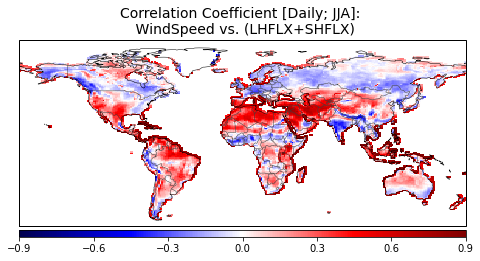

In [26]:
# ---- Maps of correlation coefficients ---- # 

# Make corrcoef cyclic for plotting
rValue_spdTotal_daily_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(rValue_spdTotal_daily, lon)

# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(8, 5),subplot_kw={'projection':ccrs.PlateCarree()})

# Set limits of plot
ax1.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# Plot spd vs. SH 
contour_plot = ax1.pcolormesh(lon_cyclic,lat, rValue_spdTotal_daily_cyclic,
                                 vmax = 0.9, vmin = -0.9, cmap = 'seismic')
ax1.set_title('Correlation Coefficient [Daily; JJA]: \n WindSpeed vs. (LHFLX+SHFLX)', fontsize=14)
# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()




###  2.4 Compare monthly v. daily in other seasons too?

In [193]:
# Now pick out DJF values: 
sfcWindSpd_DJF = sfcWindSpd_land[iDJF,:,:]
sfcWindVar_DJF = sfcWindVar_land[iDJF,:,:]
SHFLX_DJF      = SHFLX_land[iDJF,:,:]

sfcWindSpd_DJF_daily = sfcWindSpd_land_daily[iDJF_daily,:,:]
SHFLX_DJF_daily      = SHFLX_land_daily[iDJF_daily,:,:]


In [197]:
# Now pick out MAM values: 
sfcWindSpd_MAM = sfcWindSpd_land[iMAM,:,:]
sfcWindVar_MAM = sfcWindVar_land[iMAM,:,:]
SHFLX_MAM      = SHFLX_land[iMAM,:,:]

sfcWindSpd_MAM_daily = sfcWindSpd_land_daily[iMAM_daily,:,:]
SHFLX_MAM_daily      = SHFLX_land_daily[iMAM_daily,:,:]

In [198]:
# Global regression between wind SPEED and abs(SHFLX) (daily means)

# Define empty arrays...
slope_spdSH_DJF       = np.full([len(lat), len(lon)], np.nan)
rValue_spdSH_DJF      = np.full([len(lat), len(lon)], np.nan)
slope_spdSH_DJFdaily  = np.full([len(lat), len(lon)], np.nan)
rValue_spdSH_DJFdaily = np.full([len(lat), len(lon)], np.nan)

slope_spdSH_MAM       = np.full([len(lat), len(lon)], np.nan)
rValue_spdSH_MAM      = np.full([len(lat), len(lon)], np.nan)
slope_spdSH_MAMdaily  = np.full([len(lat), len(lon)], np.nan)
rValue_spdSH_MAMdaily = np.full([len(lat), len(lon)], np.nan)

for ilat in range(len(lat)):
    for ilon in range(len(lon)):
        # ------------ DJF ----------------
        # Perform linear regression on monthly data 
        slope_spdSH_DJF[ilat,ilon], intrcpt, rValue_spdSH_DJF[ilat,ilon], pVal, std_err = stats.linregress(sfcWindSpd_DJF[:,ilat,ilon],
                                                                                                   np.abs(SHFLX_DJF[:,ilat,ilon]))
        
        # Perform linear regression on daily data 
        slope_spdSH_DJFdaily[ilat,ilon], intrcpt, rValue_spdSH_DJFdaily[ilat,ilon], pVal, std_err = stats.linregress(sfcWindSpd_DJF_daily[:,ilat,ilon],
                                                                                                   np.abs(SHFLX_DJF_daily[:,ilat,ilon]))


        # ------------ MAM ----------------
        # Perform linear regression on monthly data 
        slope_spdSH_MAM[ilat,ilon], intrcpt, rValue_spdSH_MAM[ilat,ilon], pVal, std_err = stats.linregress(sfcWindSpd_MAM[:,ilat,ilon],
                                                                                                   np.abs(SHFLX_MAM[:,ilat,ilon]))
        
        # Perform linear regression on daily data 
        slope_spdSH_MAMdaily[ilat,ilon], intrcpt, rValue_spdSH_MAMdaily[ilat,ilon], pVal, std_err = stats.linregress(sfcWindSpd_MAM_daily[:,ilat,ilon],
                                                                                                   np.abs(SHFLX_MAM_daily[:,ilat,ilon]))



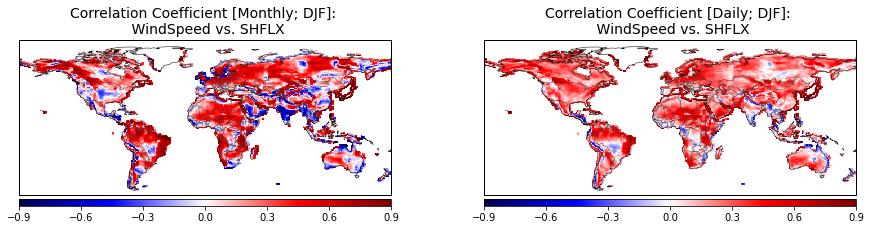

In [195]:
# ---- Maps of correlation coefficients ---- # 
# --------------- DJF ---------------------- #

# Make corrcoef cyclic for plotting
rValue_spdSH_cyclic, lon_cyclic       = cartopy.util.add_cyclic_point(rValue_spdSH_DJF, lon)
rValue_spdSH_cyclic_daily, lon_cyclic = cartopy.util.add_cyclic_point(rValue_spdSH_DJFdaily, lon)


# Set up figure
fig, axs = plt.subplots(1,2, figsize=(15, 5),subplot_kw={'projection':ccrs.PlateCarree()})
#Put axs handles in array, axs 
axs = axs.ravel()
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.25)
# Set limits of plot
axs[0].set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
axs[1].set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
# Add coastlines 
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# Plot spd vs. SH 
contour_plot = axs[0].pcolormesh(lon_cyclic,lat, rValue_spdSH_cyclic,
                                 vmax = 0.9, vmin = -0.9, cmap = 'seismic')
axs[0].set_title('Correlation Coefficient [Monthly; DJF]: \n WindSpeed vs. SHFLX', fontsize=14)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

# Plot var vs. SH
contour_plot = axs[1].pcolormesh(lon_cyclic,lat, rValue_spdSH_cyclic_daily,
                                 vmax = 0.9, vmin = -0.9, cmap = 'seismic')
axs[1].set_title('Correlation Coefficient [Daily; DJF]: \n WindSpeed vs. SHFLX', fontsize=14)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()



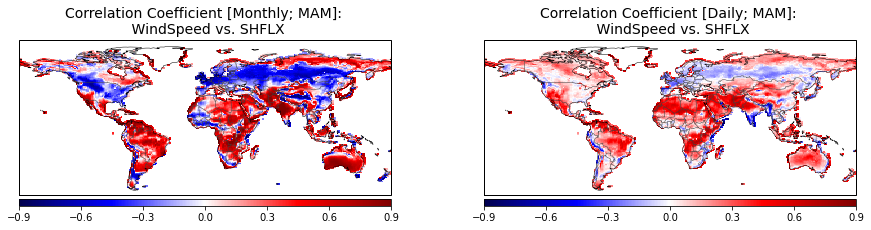

In [199]:
# ---- Maps of correlation coefficients ---- # 
# --------------- MAM ---------------------- #

# Make corrcoef cyclic for plotting
rValue_spdSH_cyclic, lon_cyclic       = cartopy.util.add_cyclic_point(rValue_spdSH_MAM, lon)
rValue_spdSH_cyclic_daily, lon_cyclic = cartopy.util.add_cyclic_point(rValue_spdSH_MAMdaily, lon)


# Set up figure
fig, axs = plt.subplots(1,2, figsize=(15, 5),subplot_kw={'projection':ccrs.PlateCarree()})
#Put axs handles in array, axs 
axs = axs.ravel()
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.25)
# Set limits of plot
axs[0].set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
axs[1].set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
# Add coastlines 
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# Plot spd vs. SH 
contour_plot = axs[0].pcolormesh(lon_cyclic,lat, rValue_spdSH_cyclic,
                                 vmax = 0.9, vmin = -0.9, cmap = 'seismic')
axs[0].set_title('Correlation Coefficient [Monthly; MAM]: \n WindSpeed vs. SHFLX', fontsize=14)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

# Plot var vs. SH
contour_plot = axs[1].pcolormesh(lon_cyclic,lat, rValue_spdSH_cyclic_daily,
                                 vmax = 0.9, vmin = -0.9, cmap = 'seismic')
axs[1].set_title('Correlation Coefficient [Daily; MAM]: \n WindSpeed vs. SHFLX', fontsize=14)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()




## 3. Compare to FLUXNET observed correlation coefficients 

In [25]:
# --------------------------------------
# Define data directory: 
# --------------------------------------
fluxnetDir   = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/FLUXNET2015/'

# --------------------------------------
# Get general site info
# --------------------------------------
siteInfoFile = fluxnetDir+'SiteList.csv'
# Now read that CSV file into a pandas dataframe 
siteInfoDF = pd.read_csv(siteInfoFile)

# Print out information available:
print('Available site characteristics (metadata) include: \n\n', siteInfoDF.columns.values, '\n')

# --------------------------------------
# And read in metadata for good measure
# --------------------------------------
metadataFile = fluxnetDir+'FLX_AA-Flx_BIF_ALL_20200501/FLX_AA-Flx_BIF_DD_20200501.xlsx'

# Read in that file 
metadataDF = pd.read_excel(metadataFile)


Available site characteristics (metadata) include: 

 ['SITE_ID' 'SITE_NAME' 'FLUXNET2015' 'FLUXNET-CH4' 'LOCATION_LAT'
 'LOCATION_LONG' 'LOCATION_ELEV' 'IGBP' 'MAT' 'MAP'] 



In [29]:
# --------------------------------------
# Get a list of all fluxnet data files
# --------------------------------------
dataFiles = glob.glob(fluxnetDir + 'FLX_*/*SUBSET_DD*')


In [30]:
# ------------------------------------------
# Define a function to read in FLUXNET data 
# ------------------------------------------

# --------------------------------------------------------
# Function to read requested variables from FLUXNET file. 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# 
# Inputs:  fileName --> Full path to FLUXNET data file 
#          varNames --> An array of variable names to be 
#                       retrieved from said data file. 
#                       NOTE: If you wish to retrieve *all* 
#                       variables, pass the string 'ALL'. 
#  
# Outputs: fluxnetID --> ID string used to identify station
#          fluxnetDS --> An x-array dataset containing the 
#                        requested variables.
#                        Missing values will be set to NaN. 
# 
# --------------------------------------------------------

def readFLUXNET_var(fileName, varNames): 
    # Get ID of station 
    startID   = fileName.find('FLX_')
    fluxnetID = fileName[startID+4:startID+10]
    
    # print('Reading in site - ', fluxnetID)
    
    # Read in CSV file containing data 
    dataDF = pd.read_csv(fileName)
    
    # Return ALL variables from dataDF if requested
    if varNames=='ALL':
        fluxnetDF = dataDF
        
        # Set any value that's missing to NaN (not -999)
        fluxnetDF = fluxnetDF.replace(-9999, np.nan)

        
        # If time has been requested, reformat to pandas make index
        fluxnetDF['TIMESTAMP'] = pd.to_datetime(fluxnetDF['TIMESTAMP'].values, format='%Y%m%d')
        fluxnetDF = fluxnetDF.set_index(['TIMESTAMP'])
        
        # Convert dataframe to Xarray Dataset (required to use coupling metrics toolbox)
        fluxnetDS = fluxnetDF.to_xarray()
            
    # Reduce returned DF to contain only variables of interest  
    else:
        
        # Check that requested variables are available in specific file
        errCount = 0                       # Initialize flag for error 
        colNames = dataDF.columns.values   # Available variables in file 
        
        for iVar in range(len(varNames)):  # Check each variable individually
            if (varNames[iVar] in colNames)==False:
                # Turn on print statement for more verbose output
                # print('** ERROR: %13s   not contained in file for %8s  **' %(varNames[iVar], fluxnetID))
                
                # If any variable is not conatined in file, return a NaN 
                fluxnetDS = -999
                errCount  = errCount+1
                
        # If all the variables *are* available, isolate those in DF and return that
        if errCount == 0: 
            fluxnetDF = dataDF[varNames]
            
            # Set any value that's missing to NaN (not -999)
            fluxnetDF = fluxnetDF.replace(-9999, np.nan)
            
            # If time has been requested, reformat to pandas make index
            if ('TIMESTAMP' in varNames)==True:
                fluxnetDF['TIMESTAMP'] = pd.to_datetime(fluxnetDF['TIMESTAMP'].values, format='%Y%m%d')
                fluxnetDF = fluxnetDF.set_index(['TIMESTAMP'])
        
            # Convert dataframe to Xarray Dataset (required to use coupling metrics toolbox)
            fluxnetDS = fluxnetDF.to_xarray()
    
    return(fluxnetID, fluxnetDS)



In [70]:
# Define emtpy arrays to save stuff into 
lat_fluxnet             = np.full([len(dataFiles)], np.nan)
lon_fluxnet             = np.full([len(dataFiles)], np.nan)
stationID               = []
allStationID            = []
monthsUsed              = []    # JJA months used to compute corrcoef
corrCoefDaily_SHvWS     = []
corrCoefDaily_LHvWS     = []
corrCoefDaily_SHLHvWS   = []
corrCoefMonthly_SHvWS   = []
corrCoefMonthly_LHvWS   = []
corrCoefMonthly_SHLHvWS = []


# Variables I want returned:
varNames = ['TIMESTAMP','H_F_MDS','WS_F','LE_F_MDS']

# Loop over each station (data file)
for iStation in range(len(dataFiles)):
    
    # Read in data 
    # ----------------------------------------------------------
    fluxnetID,fluxnetDS = readFLUXNET_var(dataFiles[iStation], varNames)
    
    # Save lat and lon for this station 
    # ----------------------------------------------------------
    indStation            = np.where(fluxnetID==siteInfoDF['SITE_ID'])
    lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
    lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
    allStationID.append(fluxnetID)
    
    # Check that there was data saved for this particular site: 
    # ----------------------------------------------------------
    if (type(fluxnetDS)==int):
        print('No data for station: %8s' % fluxnetID)
    
    elif ( (np.all(np.isnan(fluxnetDS['H_F_MDS']))==True) | (np.all(np.isnan(fluxnetDS['WS_F']))==True) | (np.all(np.isnan(fluxnetDS['LE_F_MDS']))==True) ):
        print('No data for station: %8s' % fluxnetID)
        
    # If data is present: 
    # ----------------------------------------------------------
    else:        
        # Only consider where data is actually present for selected vars
        iReal      = np.where((np.isfinite(fluxnetDS['LE_F_MDS'])==True) & 
                              (np.isfinite(fluxnetDS['H_F_MDS'])==True) & 
                              (np.isfinite(fluxnetDS['WS_F'])==True))[0]
        fluxnetDS  = fluxnetDS.isel(TIMESTAMP=iReal)
        # Save station ID if it has data 
        stationID.append(fluxnetID)   
        
        # Check how long data is available for and isolate JJA 
        # -----------------------------------------------------------
        startTime_fluxnet = fluxnetDS['TIMESTAMP'].values[0]
        endTime_fluxnet   = fluxnetDS['TIMESTAMP'].values[-1]
        
        dateRange = pd.date_range(start=startTime_fluxnet,end=endTime_fluxnet,freq='M')
        nMonths   = len(np.where((dateRange.month>=6) & (dateRange.month<=8))[0])
        # Save number of JJA months used - may want to vary cutoff point later
        monthsUsed.append(nMonths)
        
        # Get iJJA (daily data):
        datesFLUXNET  = pd.DatetimeIndex(fluxnetDS['TIMESTAMP'].values) 
        iJJA_station  = np.where((datesFLUXNET.month>=6) & (datesFLUXNET.month<=8))[0]
        fluxnetDS_JJA = fluxnetDS.isel(TIMESTAMP=iJJA_station)
            
        # Upsample to monthly too... 
        fluxnetDS_JJAmonthly = fluxnetDS_JJA.resample(TIMESTAMP="1MS").mean()
        # Resampling to monthly fills in empty months with NaNs, so get just JJA
        datesMonthlyFLUXNET  = pd.DatetimeIndex(fluxnetDS_JJAmonthly['TIMESTAMP'].values) 
        iJJA_MonthlyStation  = np.where((datesMonthlyFLUXNET.month>=6) & (datesMonthlyFLUXNET.month<=8))[0]
        fluxnetDS_JJAmonthly = fluxnetDS_JJAmonthly.isel(TIMESTAMP=iJJA_MonthlyStation)
        
        # Get correlation coefficients for JJA data 
        # -----------------------------------------------------------
        totalFlx = fluxnetDS_JJA.H_F_MDS.values +  fluxnetDS_JJA.LE_F_MDS.values

        # Perform linear regression on daily data 
        slope, intrcpt, rValue_FLUXdaily_spdSH, pVal, std_err = stats.linregress(fluxnetDS_JJA.WS_F.values,
                                                                            np.abs(fluxnetDS_JJA.H_F_MDS.values))

        slope, intrcpt, rValue_FLUXdaily_spdLH, pVal, std_err = stats.linregress(fluxnetDS_JJA.WS_F.values,
                                                                           np.abs(fluxnetDS_JJA.LE_F_MDS.values))

        slope, intrcpt, rValue_FLUXdaily_spdTotal, pVal, std_err = stats.linregress(fluxnetDS_JJA.WS_F.values,
                                                                           totalFlx)
        # Save to larger arrays 
        corrCoefDaily_SHvWS.append(rValue_FLUXdaily_spdSH)
        corrCoefDaily_LHvWS.append(rValue_FLUXdaily_spdLH)
        corrCoefDaily_SHLHvWS.append(rValue_FLUXdaily_spdTotal)
        
        # . . . . . . . . . . . . . . . . . . . . . . .
        
        # Perform linear regression on monthly data 
        totalFlx = fluxnetDS_JJAmonthly.H_F_MDS.values + fluxnetDS_JJAmonthly.LE_F_MDS.values

        # Perform linear regression on daily data 
        slope, intrcpt, rValue_FLUXmonthly_spdSH, pVal, std_err = stats.linregress(fluxnetDS_JJAmonthly.WS_F.values,
                                                                            np.abs(fluxnetDS_JJAmonthly.H_F_MDS.values))

        slope, intrcpt, rValue_FLUXmonthly_spdLH, pVal, std_err = stats.linregress(fluxnetDS_JJAmonthly.WS_F.values,
                                                                            np.abs(fluxnetDS_JJAmonthly.LE_F_MDS.values))

        slope, intrcpt, rValue_FLUXmonthly_spdTotal, pVal, std_err = stats.linregress(fluxnetDS_JJAmonthly.WS_F.values,
                                                                           totalFlx)
        # Save to larger arrays 
        corrCoefMonthly_SHvWS.append(rValue_FLUXmonthly_spdSH)
        corrCoefMonthly_LHvWS.append(rValue_FLUXmonthly_spdLH)
        corrCoefMonthly_SHLHvWS.append(rValue_FLUXmonthly_spdTotal)
        

In [76]:
# Print some summary information 
print('Number of stations that can be used:        %i' % len(corrCoefMonthly_SHvWS))
print('Lowest number of months used for corrCoef:  %i' % np.nanmin(monthsUsed))
print('Highest number of months used for corrCoef: %i' % np.nanmax(monthsUsed))
print('Number of stations using less than 3 years: %i' % (len(np.where(np.asarray(monthsUsed)<9)[0])))
print('Number of stations using less than 5 years: %i' % (len(np.where(np.asarray(monthsUsed)<15)[0])))


Number of stations that can be used:        205
Lowest number of months used for corrCoef:  3
Highest number of months used for corrCoef: 66
Number of stations using less than 3 years: 29
Number of stations using less than 5 years: 89


In [92]:
# Let' set a limit of needing 5 years of data...
iLimYears = 5 
iKeep     = np.where(np.asarray(monthsUsed)>=iLimYears*3)[0]

lat_fluxnetKeep              = lat_fluxnet[iKeep]
lon_fluxnetKeep              = lon_fluxnet[iKeep]
stationIDKeep                = np.asarray(stationID)[iKeep]
monthsUsedKeep               = np.asarray(monthsUsed)[iKeep]

corrCoefDaily_SHvWS_keep     = np.asarray(corrCoefDaily_SHvWS)[iKeep]
corrCoefDaily_LHvWS_keep     = np.asarray(corrCoefDaily_LHvWS)[iKeep]
corrCoefDaily_SHLHvWS_keep   = np.asarray(corrCoefDaily_SHLHvWS)[iKeep]
corrCoefMonthly_SHvWS_keep   = np.asarray(corrCoefMonthly_SHvWS)[iKeep]
corrCoefMonthly_LHvWS_keep   = np.asarray(corrCoefMonthly_LHvWS)[iKeep]
corrCoefMonthly_SHLHvWS_keep = np.asarray(corrCoefMonthly_SHLHvWS)[iKeep]


**Start Plotting**


Finally figured out how to actually map a value to the colorbar here: https://stackoverflow.com/questions/15140072/how-to-map-number-to-color-using-matplotlibs-colormap <br> 
Woohoo! 

In [156]:
# --- Set up discrete colorbar ---
import matplotlib as mpl
import matplotlib.cm as cm

cmap = plt.cm.seismic  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

bounds = np.arange(-0.9, 1.0, 0.2)
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N)
m      = cm.ScalarMappable(norm=norm,cmap=cmap)


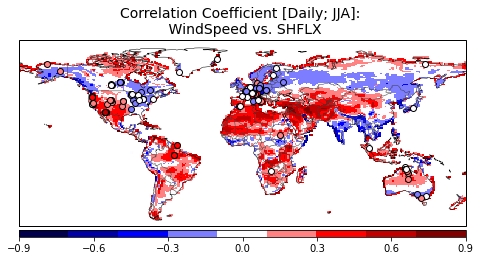

In [154]:
# ---- Maps of correlation coefficients ---- # 

# Make corrcoef cyclic for plotting
rValue_spdSH_daily_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(rValue_spdSH_daily, lon)

# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(8, 5),subplot_kw={'projection':ccrs.PlateCarree()})

# Set limits of plot
ax1.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# Plot spd vs. SH 
contour_plot = ax1.pcolormesh(lon_cyclic,lat, rValue_spdSH_daily_cyclic,
                                 vmin = bounds[0], vmax = bounds[-2], 
                                 cmap = cmap, norm=norm)
ax1.set_title('Correlation Coefficient [Daily; JJA]: \n WindSpeed vs. SHFLX', fontsize=14)
# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()


# ----------- Add FluxNet measurements ------------ 
for iStation in range(len(iKeep)):

    ax1.plot(lon_fluxnetKeep[iStation],lat_fluxnetKeep[iStation],'o',
        markerfacecolor=m.to_rgba(corrCoefDaily_SHvWS_keep[iStation]),
        markeredgecolor='k',
        markersize=6,
        transform=ccrs.PlateCarree())
        

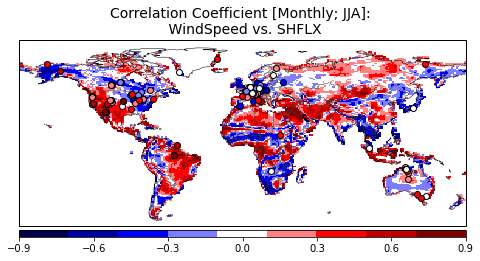

In [160]:
# ---- Maps of correlation coefficients ---- # 

# Make corrcoef cyclic for plotting
rValue_spdSH_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(rValue_spdSH, lon)

# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(8, 5),subplot_kw={'projection':ccrs.PlateCarree()})

# Set limits of plot
ax1.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# Plot spd vs. SH 
contour_plot = ax1.pcolormesh(lon_cyclic,lat, rValue_spdSH_cyclic,
                                 vmin = bounds[0], vmax = bounds[-2], 
                                 cmap = cmap, norm=norm)
ax1.set_title('Correlation Coefficient [Monthly; JJA]: \n WindSpeed vs. SHFLX', fontsize=14)
# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

# ----------- Add FluxNet measurements to monthly data ------------ 
for iStation in range(len(iKeep)):

    ax1.plot(lon_fluxnetKeep[iStation],lat_fluxnetKeep[iStation],'o',
        markerfacecolor=m.to_rgba(corrCoefMonthly_SHvWS_keep[iStation]),
        markeredgecolor='k',
        markersize=6,
        transform=ccrs.PlateCarree())


        


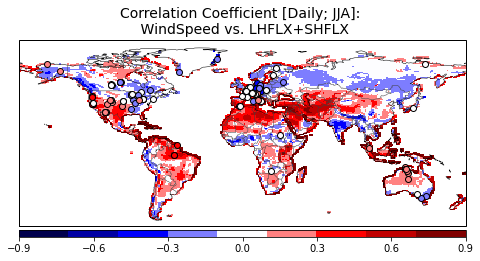

In [161]:
# ---- Maps of correlation coefficients ---- # 

# Make corrcoef cyclic for plotting
rValue_spdTotal_daily_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(rValue_spdTotal_daily, lon)

# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(8, 5),subplot_kw={'projection':ccrs.PlateCarree()})

# Set limits of plot
ax1.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# Plot spd vs. SH 
contour_plot = ax1.pcolormesh(lon_cyclic,lat, rValue_spdTotal_daily_cyclic,
                                 vmin = bounds[0], vmax = bounds[-2], 
                                 cmap = cmap, norm=norm)
ax1.set_title('Correlation Coefficient [Daily; JJA]: \n WindSpeed vs. LHFLX+SHFLX', fontsize=14)
# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()


# ----------- Add FluxNet measurements ------------ 
for iStation in range(len(iKeep)):

    ax1.plot(lon_fluxnetKeep[iStation],lat_fluxnetKeep[iStation],'o',
        markerfacecolor=m.to_rgba(corrCoefDaily_SHLHvWS_keep[iStation]),
        markeredgecolor='k',
        markersize=6,
        transform=ccrs.PlateCarree())
        

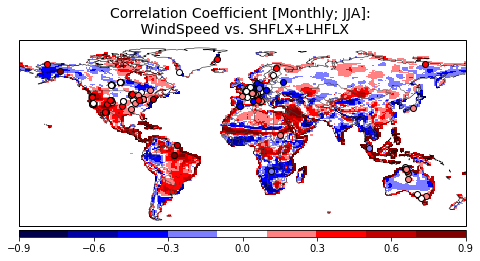

In [162]:
# ---- Maps of correlation coefficients ---- # 

# Make corrcoef cyclic for plotting
rValue_spdTotal_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(rValue_spdTotal, lon)

# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(8, 5),subplot_kw={'projection':ccrs.PlateCarree()})

# Set limits of plot
ax1.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# Plot spd vs. SH 
contour_plot = ax1.pcolormesh(lon_cyclic,lat, rValue_spdTotal_cyclic,
                                 vmin = bounds[0], vmax = bounds[-2], 
                                 cmap = cmap, norm=norm)
ax1.set_title('Correlation Coefficient [Monthly; JJA]: \n WindSpeed vs. SHFLX+LHFLX', fontsize=14)
# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

# ----------- Add FluxNet measurements to monthly data ------------ 
for iStation in range(len(iKeep)):

    ax1.plot(lon_fluxnetKeep[iStation],lat_fluxnetKeep[iStation],'o',
        markerfacecolor=m.to_rgba(corrCoefMonthly_SHLHvWS_keep[iStation]),
        markeredgecolor='k',
        markersize=6,
        transform=ccrs.PlateCarree())


**What does mean absolute bias look like?**

In [167]:
# Define empty arrays to save differences in 
spdSH_MonthlyDiff    = np.full([len(iKeep)], np.nan)
spdSH_DailyDiff      = np.full([len(iKeep)], np.nan)
spdTotal_MonthlyDiff = np.full([len(iKeep)], np.nan)
spdTotal_DailyDiff   = np.full([len(iKeep)], np.nan)

# Consider each station individually 
for iStation in range(len(iKeep)):
    
    # Isolate station CI for JJA
    fluxnetDaily_spdSH   = corrCoefDaily_SHvWS_keep[iStation]
    fluxnetMonthly_spdSH = corrCoefMonthly_SHvWS_keep[iStation]
    
    fluxnetDaily_spdTotal   = corrCoefDaily_SHLHvWS_keep[iStation]
    fluxnetMonthly_spdTotal = corrCoefMonthly_SHLHvWS_keep[iStation]
    
    # Get model gridcells that match fluxnet site 
    iLat        = np.where( (lat>=(lat_fluxnetKeep[iStation]-0.4712)) & 
                            (lat<=(lat_fluxnetKeep[iStation]+0.4712)) )[0]
     # Convert longitude of point into 0-360 range 
    lonSel_flux = (lon_fluxnetKeep[iStation] + 360) % 360                
    iLon        = np.where( (lon>=(lonSel_flux-0.625)) & 
                            (lon<=(lonSel_flux+0.625)) )[0]

    gridValue_spdSH_Monthly    = rValue_spdSH[iLat,iLon]
    gridValue_spdSH_Daily      = rValue_spdSH_daily[iLat,iLon]
    gridValue_spdTotal_Monthly = rValue_spdTotal[iLat,iLon]
    gridValue_spdTotal_Daily   = rValue_spdTotal_daily[iLat,iLon]
    
    # Compare to fluxnet-based estimate
    spdSH_MonthlyDiff[iStation] = gridValue_spdSH_Monthly - fluxnetMonthly_spdSH
    spdSH_DailyDiff[iStation]   = gridValue_spdSH_Daily   - fluxnetDaily_spdSH
    
    spdTotal_MonthlyDiff[iStation] = gridValue_spdTotal_Monthly - fluxnetMonthly_spdTotal
    spdTotal_DailyDiff[iStation]   = gridValue_spdTotal_Daily   - fluxnetDaily_spdTotal
        

In [169]:
print('\n Mean absolute bias (|model - observations|)')
print('     spdSH_Monthly Bias: %8.3f' % np.nanmean(np.abs(spdSH_MonthlyDiff)))
print('     spdSH_Daily Bias:   %8.3f' % np.nanmean(np.abs(spdSH_DailyDiff)))
print()
print('     spdTotal_Monthly Bias: %8.3f' % np.nanmean(np.abs(spdTotal_MonthlyDiff)))
print('     spdTotal_Daily Bias:   %8.3f' % np.nanmean(np.abs(spdTotal_DailyDiff)))



 Mean absolute bias (|model - observations|)
     spdSH_Monthly Bias:    0.340
     spdSH_Daily Bias:      0.157

     spdTotal_Monthly Bias:    0.299
     spdTotal_Daily Bias:      0.189
